# YOLO - Vehicle detection and counting

track problem:
 - object are overlapped
 - very near boxes
 - can happen that an object not appears on one frame (changing ids)
 - no cv2.tracker() beacuse we cannot change the boxes shape

this is a simple tracking of the center points

for counting we use 3 lines to divide up to down and down to up, i this way we count only the vehicles that throught the 3 lines.

##Initialization of YOLO

###Abiltate GPU

In [ ]:
!gdown --id 12PuUG6pgAYH2kCf99UijQ7tSV7j_pmOD

Downloading...
From: https://drive.google.com/uc?id=12PuUG6pgAYH2kCf99UijQ7tSV7j_pmOD
To: /content/cv2.cpython-37m-x86_64-linux-gnu.so
1.01GB [00:09, 107MB/s] 


###Import function

In [ ]:
import cv2 as cv
import numpy as np
from sklearn.metrics import auc
import glob
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from google.colab.patches import cv2_imshow #we use this to show image and not cv.imshow(). This i due to the colab notebook
# Probably this lines of code will work only if they are used in google colab and not localy on a user's PC
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


change folder

In [ ]:
# Folder where all files are
PATH_FOLDER = "/content/gdrive/MyDrive/Colab Notebooks/vehicle_counting"

%cd "/content/gdrive/MyDrive/Colab Notebooks/vehicle_counting/YOLO"
%ls

[Errno 2] No such file or directory: '/content/gdrive/MyDrive/Colab Notebooks/vehicle_counting/YOLO'
/content
cv2.cpython-37m-x86_64-linux-gnu.so  gdrive/  sample_data/


Application of YOLO for vehicle detection (and counting).  
Note: In the **same folder** the user must have the **congifuration files** and **weights files** necessary to load the yolo configuration: *.cgf* and *.weights*

In [ ]:
# Import YOLO class
import yolo

ModuleNotFoundError: ignored

In [ ]:
SAVE_RESULTS = False
VERSION = 'v3'

##Import model

In [ ]:
model = yolo.YOLO(verbose=0, version=VERSION)

## Loading test images

In [ ]:
def extract_name(absolute_path):
    i = 0
    for j in range(len(absolute_path)):
        char = absolute_path[j]
        if char == '/' or char == '\\':
            i = j
    name = absolute_path[i+1:]
    return name

In [ ]:
# Loading test images
folder = PATH_FOLDER + '/test/vehicles/*'

count = 1
test = []
test_filenames = []

for path in glob.glob(folder):
  img = cv.imread(path)
  #img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  test.append(img)

  file = extract_name(path)
  test_filenames.append(file)

  print('Loaded image[{}/{}]'.format(count, len(glob.glob(folder))))
  count += 1

Loading bounding boxes

In [ ]:
df_boxes = pd.read_csv(PATH_FOLDER + '/test/via_region_data.csv', sep=',')
df_boxes.head()

In [ ]:
gt_boxes = [] # Ground truth boxes

for name in test_filenames:
  boxes = []

  rows = df_boxes[ df_boxes['filename'] == name ]
  if rows['region_count'].iloc[0] > 0:
    dic_boxes = rows['region_shape_attributes'].values
    for i in range(dic_boxes.size):
      box = dic_boxes[i]
      box = box[1:-1].split(',')[1:]
      box = [int(elem.split(':')[-1]) for elem in box]
      
      # box format = [x y width height]
      x, y, width, height = box
      boxes.append([x, y, x + width, y + height])
  gt_boxes.append(boxes)

In [ ]:
print(gt_boxes[0])

##Yolo with images

Do yolo

In [ ]:
boxesList = []
idxsList = []
classIDsList = []
confidencesList = []

for i, img in enumerate(test):
  boxes, confidences, classIDs = model.predict(img, verbose=0)

  print('Image: {}'.format(test_filenames[i]))
  #----------infomation------------
  print('[INFO] Number of boxes: {}'.format(len(boxes)))
  #print('\n[INFO] Confidence values:')
  #for c in confidences:
  #  print(c)
  print('[INFO] Classes found: {}'.format(set(classIDs)))

  #------------NMS------------
  print('---After NMS---')
  threshold_score = 0.8
  threshold_overlap = 0.2
  idxs = model.nms(boxes, confidences, threshold_score, threshold_overlap)
  print('[INFO] Number of boxes: {}'.format(len(idxs)))
  #print('\n[INFO] Confidence values:')
  #for i in idxs:
  #  print(confidences[i[0]])
  print('******************\n')

  boxesList.append(boxes)
  idxsList.append(idxs)
  classIDsList.append(classIDs)
  confidencesList.append(confidences)

print('******end*********')

Show image

In [ ]:
# Draw function
def draw_box(image, box, color, text=''):
  thickness = 2
  cv.rectangle(image, box, color, thickness)
  x = box[0]
  y = box[1]
  if text != '':
      if y - 10 < 0:
          y = box[1] + box[3] - 10
      cv.putText(image, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, thickness)

In [ ]:
# In the MS COCO dataset the ids class
# for vehicle category are numbers from 2 to 9
classes = range(2, 10)
classes_names = {2:'bicycle', 3:'car', 4:'motorcycle', 5:'airplane', 6:'bus', 7:'train',
                 8:'truck', 9:'boat'}
np.random.seed(1)
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')

final_resultList = []

for j, img in enumerate(test):
  final_result = img.copy()
  final_result = cv.resize(final_result, model.image_size)

  boxes = boxesList[j]
  idxs = idxsList[j]
  classIDs = classIDsList[j]
  confidences = confidencesList[j]

  for i in idxs:
    box = boxes[i[0]]
    score = confidences[i[0]]
    label = classIDs[i[0]]

    color = colors[label-2]
    text = '{} {:.2f}%'.format(classes_names[label], score*100)
    draw_box(final_result, box, (int(color[0]), int(color[1]), int(color[2])), text)

  final_resultList.append(final_result)

  cv2_imshow(final_result)

NameError: ignored

###counting

In [ ]:
for j, img in enumerate(test):

  boxes = boxesList[j]
  idxs = idxsList[j]
  classIDs = classIDsList[j]
  confidences = confidencesList[j]

  n_vehicles_detected = [0,0,0,0,0,0,0,0]
  n_vehicles = 0

  # look to the detected vehicles
  n_vehicles = len(idxs)
  for i in idxs:
    n_vehicles_detected[classIDs[i[0]]-2] += 1

  # print number vehicles detected
  for label in range(2,10):
    print("[INFO] Number of {}: {}".format(classes_names[label], n_vehicles_detected[label-2]))

  # show in image number of vehicles
  text = "vehicles: {}".format(n_vehicles)
  final_result_counting = final_resultList[j].copy()

  x = final_result_counting.shape[0] - 120
  y = final_result_counting.shape[1] - 10
  cv.putText(final_result_counting, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
  cv2_imshow(final_result_counting)

  if SAVE_RESULTS:
    cv.imwrite(PATH_FOLDER + '/test/results_images/yolo{}_{}'.format(VERSION, test_filenames[j]), final_result_counting)

Output hidden; open in https://colab.research.google.com to view.

### Performances

#### Utils function

In [ ]:
def iou(boxA, boxB):
    """
    Compute the IOU metric
    -----------------
    Parameters:
        boxA, boxB are list of corners, top left corner and bottom right corner
        in total 4 coordinates for box [x_tl, y_tl, x_br, y_br]
    Cite:
        https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
    """
    # computation of top left and bottom right coordinates
    # for the interseption rectangle
    xi_1 = max(boxA[0], boxB[0])
    yi_1 = max(boxA[1], boxB[1])
    xi_2 = min(boxA[2], boxB[2])
    yi_2 = min(boxA[3], boxB[3])
    
    
    # interseption area
    area_i = max(0, xi_2 - xi_1 + 1) * max(0, yi_2 - yi_1 + 1)
    
    # areas box A and box B
    area_A = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    area_B = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # Interseption over Union
    iou = area_i / float(area_A + area_B - area_i)
    return iou

In [ ]:
from collections import OrderedDict

def precision_recall_curve(groundBBoxes, predictedBBoxes, confidencesList, minThreshold=0.5):
  precisions = []
  recalls = []

  # Counting the number of ground truth boxes
  num_boxes = 0
  for i in range(len(groundBBoxes)):
      num_boxes += len(groundBBoxes[i])

  # scores
  IOUs = []
  # calculate IOUs
  for i in range(len(groundBBoxes)):
    for p in predictedBBoxes[i]:
      max_iou = 0
      for g in groundBBoxes[i]:
          local_iou = iou(g,p)
          if local_iou > max_iou: 
              max_iou = local_iou
      IOUs.append(max_iou)

  confidences = []
  for i in range(len(confidencesList)):
    for c in confidencesList[i]:
      confidences.append(c)

  # Sort by confidence
  bboxes_sorted = {confidences[i]:IOUs[i] for i in range(len(confidences))}
  bboxes_sorted = OrderedDict(sorted(bboxes_sorted.items()))
  confidences_sorted = confidences.copy()
  confidences_sorted.sort(reverse=True)

  for i in range(len(bboxes_sorted)):
    
    keys = confidences_sorted[:i+1]
    IOUs_subset = []
    for k in keys:
      IOUs_subset.append(bboxes_sorted[k])

    tpr = 0                           # true posiitve rate
    fpr = 0                           # false positive rate

    for i in IOUs_subset:
      if i >= minThreshold:
        tpr += 1
      else:
        fpr += 1

    p = tpr / (tpr + fpr)             # precision
    r = tpr / num_boxes               # recall

    precisions.append(p)
    recalls.append(r)

  return precisions, recalls

#### Analisys

In yolo for detection of object the images must be rescaled according to the model input size parameter, otherwise the CNN cannot be applied (a CNN have a fixed input size). The output boxes have then coordinates that matches the input size of the image in the model. Therefore in order to be consiste with this notation the coordinates of the ground truth boxes are changed accordingly.

In [ ]:
predicted_boxes = []
predicted_confidences = []
for j, img in enumerate(test):
  boxes = boxesList[j]
  idxs = idxsList[j]
  scores = confidencesList[j]

  # from [x, y, w, h] to [x_tl, y_tl, x_br, y_br]
  # tl means top-left corner
  # br means bottom-right corner
  predicted_boxes.append([[boxes[i[0]][0], boxes[i[0]][1], boxes[i[0]][2] + boxes[i[0]][0], boxes[i[0]][3] + boxes[i[0]][1] ] for i in idxs])
  predicted_confidences.append([scores[i[0]] for i in idxs])

In [ ]:
new_gt_boxes = []

for i in range(len(gt_boxes)):
  if len(gt_boxes[i]) > 0:
    boxes = gt_boxes[i]
    boxes = np.array(boxes)

    col0 = boxes[:,0] / test[i].shape[1] * model.image_size[1]
    col2 = boxes[:,2] / test[i].shape[1] * model.image_size[1]
    col1 = boxes[:,1] / test[i].shape[0] * model.image_size[0]
    col3 = boxes[:,3] / test[i].shape[0] * model.image_size[0]

    boxes = np.vstack((col0.astype(int).T, col1.astype(int).T, col2.astype(int).T, col3.astype(int).T)).T

    new_gt_boxes.append(boxes.tolist())

Evaluation metrics:

In [ ]:
# threhsold for precision-recall curve
# and also for mAP
th = 0.1 
precisions, recalls = precision_recall_curve(new_gt_boxes, predicted_boxes, predicted_confidences, th)

In [ ]:
# Save results
if SAVE_RESULTS:
  np.savetxt(PATH_FOLDER + '/performances_analysis/yolo{}_precisions{}.txt'.format(VERSION, th), np.array(precisions))
  np.savetxt(PATH_FOLDER + '/performances_analysis/yolo{}_recalls_{}.txt'.format(VERSION, th), np.array(recalls))

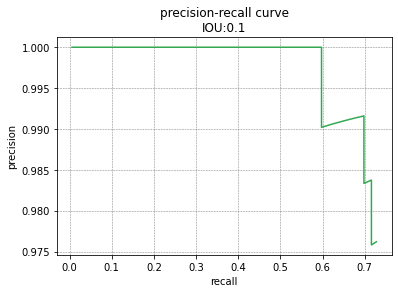

In [ ]:
#for i in range(len(precisions)):
#  print(recalls[i], ' ', precisions[i])

fig, ax = plt.subplots(1,1)
ax.plot(recalls, precisions, color='#32a852')
ax.set_xlabel('recall')
ax.set_ylabel('precision')
ax.set_title('precision-recall curve\nIOU:{}'.format(th), fontsize=12)
ax.grid(color='gray', linestyle='--', linewidth=0.5)

Our only class of interest is **vehicle**, therefor in this context Average Precision (AP) and Mean Average Precision (mAP) are equivalent.

In [ ]:
mAP = auc(recalls, precisions)
print('mAP: {:.2f}%'.format(mAP * 100))

mAP: 72.04%


In [ ]:
if SAVE_RESULTS:
  f = open(PATH_FOLDER + '/performances_analysis/yolo{}_mAP.txt'.format(VERSION), 'a')
  f.write('mAP {}: {:.2f}%\n'.format(th, mAP * 100))
  f.close()

## Video

###Import

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import imutils #per il resize mantenendo aspect ratio
import time

In [ ]:
import CentroidTracker

###counting function


In [ ]:
def count_vehicle(objects, up_line_position, down_line_position, temp, n_vehicles_up, n_vehicles_down):
  # prepare dict
  for (objectID, centroid) in objects.items():
    if centroid[1] > up_line_position and centroid[1] < down_line_position and objectID not in temp.keys():
      temp[objectID] = centroid[1]
  elim = []
  # up
  for id in temp.keys():
    #check esistence may be is eliminate
    if id not in objects.keys():
      elim.append(id)
      continue
    if objects[id][1] > down_line_position:
      n_vehicles_up += 1
      elim.append(id)
    if objects[id][1] < up_line_position:
      n_vehicles_down += 1
      elim.append(id)
  for id in elim:
    del temp[id]

  return n_vehicles_up, n_vehicles_down, temp

###Yolo in video

up is from up to down
down is from down to up

In [ ]:
colors = np.random.randint(0, 255, size=(len(classes), 3), dtype='uint8')
#load the video and see it
cap = cv.VideoCapture(PATH_FOLDER + '/test/video/video_53sec.mp4')
#print(cap.get(cv.CAP_PROP_FPS)) #di default e non si riesce a cambiare, resta sempre 60
fps = cap.get(cv.CAP_PROP_FPS)
w = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

#write video
save_path = PATH_FOLDER + '/test/results_video/yolo{}_53sec.mp4'.format(VERSION)
fourcc = cv.VideoWriter_fourcc(*'MP4V')
vid_writer = cv.VideoWriter(save_path, fourcc, fps, (w,h))

count = 0 #count frame of the video
n_vehicles_up = 0 #initialization counting vehicles
n_vehicles_down = 0
temp = {} # vehicles between middle and up, they go down. id:y_centroid

t_in = time.time() #time to see the required time for see all the video

#initialize counter
ct = CentroidTracker.CentroidTracker(maxDistance=75, maxDisappeared=40)

times = []
print('Processing...\n')

while cap.isOpened():
  #capture the frame
  ret, frame = cap.read()
  
  #check if frame read correctly
  if not ret:
    print("Exiting...")
    break

  #conto i vari frame
  count += 1

  #test using Selective search segmentation
  t0 = time.time()

  #predict
  boxes, confidences, classIDs, t = model.predict(frame, verbose=1)
  times.append(t)
  idxs = model.nms(boxes, confidences, threshold_score, threshold_overlap) #for nms

  # draw rectangle
  img = frame.copy()
  img = cv.resize(img, model.image_size)

  # rects for tracking
  rects = []

  # draw boxes
  for i in idxs:
    box = boxes[i[0]]
    score = confidences[i[0]]
    label = classIDs[i[0]]
    rects.append(box)

    color = colors[label-2]
    text = '{} {:.2f}%'.format(classes_names[label], score*100)
    draw_box(img, box, (int(color[0]), int(color[1]), int(color[2])), text)

  # update trackers
  objects = ct.update(rects)
  # loop over the tracked objects
  for (objectID, centroid) in objects.items():
		# draw both the ID of the object and the centroid of the
		# object on the output frame
    text = "ID {}".format(objectID)
    cv.putText(img, text, (centroid[0] - 10, centroid[1] - 10),
			cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv.circle(img, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

  # draw 3 line
  middle_line_position = int(img.shape[1]/2)
  up_line_position = middle_line_position - 15
  down_line_position = middle_line_position + 15
  cv.line(img, (0,up_line_position), (img.shape[0], up_line_position), (255,255,255), 2)
  cv.line(img, (0,down_line_position), (img.shape[0], down_line_position), (255,255,255), 2)

  # print the count in the image
  n_vehicles_up, n_vehicles_down, temp = count_vehicle(objects, up_line_position, down_line_position, temp, n_vehicles_up, n_vehicles_down)
  
  text = "vehicles up: {}".format(n_vehicles_up)
  x = img.shape[0] - 150
  y = img.shape[1] - 10
  cv.putText(img, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)
  text = "vehicles down: {}".format(n_vehicles_down)
  x = img.shape[0] - 150
  y = img.shape[1] - 25
  cv.putText(img, text, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

  # draw in the video
  img = cv.resize(img, (w,h)) # così ha la stessa size dichiarata nel videoWriter
  vid_writer.write(img)

#total time to see video
t = time.time()
print("AVERAGE STATISTICS: ")
print("Time total={}".format(t-t_in))
print('Mean time for a computation: {}'.format(np.mean(times)))
print("Detection FPS={}".format(count/(t-t_in)))
print("Video FPS={}".format(fps))

vid_writer.release()
cap.release()

Processing...

time=0.08031392097473145
time=0.09152817726135254
time=0.09171605110168457
time=0.09064340591430664
time=0.09095025062561035
time=0.09085679054260254
time=0.09172368049621582
time=0.09055161476135254
time=0.09044408798217773
time=0.09082889556884766
time=0.09202337265014648
time=0.09154534339904785
time=0.09177875518798828
time=0.09227776527404785
time=0.0917057991027832
time=0.09136962890625
time=0.09016752243041992
time=0.09034061431884766
time=0.09052371978759766
time=0.09124112129211426
time=0.09153580665588379
time=0.09181809425354004
time=0.09161567687988281
time=0.09033203125
time=0.09080743789672852
time=0.09107184410095215
time=0.09097170829772949
time=0.09147858619689941
time=0.09095478057861328
time=0.09167313575744629
time=0.09016537666320801
time=0.0913381576538086
time=0.09089183807373047
time=0.09081006050109863
time=0.08973097801208496
time=0.0900726318359375
time=0.09112405776977539
time=0.09047627449035645
time=0.09103918075561523
time=0.089709520339965

###See video with detection

In [ ]:
'''
path_video = PATH_FOLDER + '/test/results_video/yolo{}_15sec.mp4'.format(VERSION)

# Show video
mp4 = open(path_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
'''

'\npath_video = PATH_FOLDER + \'/test/results_video/yolo{}_15sec.mp4\'.format(VERSION)\n\n# Show video\nmp4 = open(path_video,\'rb\').read()\ndata_url = "data:video/mp4;base64," + b64encode(mp4).decode()\nHTML("""\n<video width=400 controls>\n      <source src="%s" type="video/mp4">\n</video>\n""" % data_url)\n'

###See video without detection

In [ ]:
'''
path_video = PATH_FOLDER + "/test/video/video_15sec.mp4"

# Show video
mp4 = open(path_video,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)
'''

'\npath_video = PATH_FOLDER + "/test/video/video_15sec.mp4"\n\n# Show video\nmp4 = open(path_video,\'rb\').read()\ndata_url = "data:video/mp4;base64," + b64encode(mp4).decode()\nHTML("""\n<video width=400 controls>\n      <source src="%s" type="video/mp4">\n</video>\n""" % data_url)\n'